### Loading libaries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import nltk
nltk.download('stopwords')


In [2]:
df = pd.read_csv(r'/content/spam.csv',  encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


First observations:

In [3]:
df.shape

(5572, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data cleaning

Remove unnecessary variables:

In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Rename columns:

In [7]:
df.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We change column "Class" to 0 and 1:

- spam = 1
- ham = 0

In [8]:
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['Text'][1]

'Ok lar... Joking wif u oni...'

In [10]:
df['Text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

### Basic EDA

We check proportion Class variable:

In [11]:
df['Class'].value_counts()

0    4825
1     747
Name: Class, dtype: int64

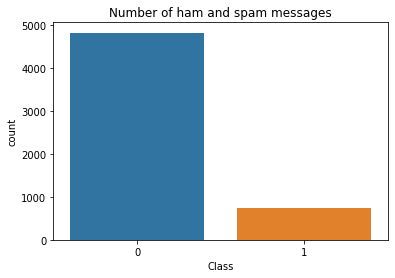

In [12]:
sns.countplot(x='Class',data=df)
plt.xlabel('Class')
plt.title('Number of ham and spam messages');

The target class variable is imbalanced, where "ham" values are more dominating than "spam".

In [13]:
df.describe()

,Class
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Length of text messages:

In [16]:
df['length'] = df.Text.apply(len)
df.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


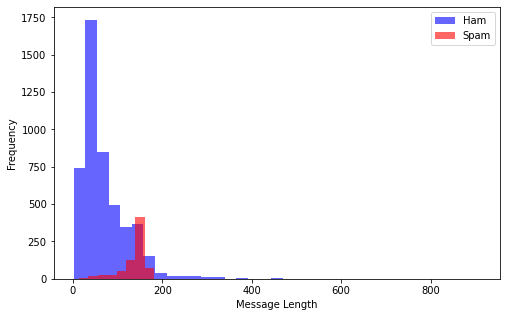

In [17]:
plt.figure(figsize=(8, 5))
df[df.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length");

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc217011d10>,
      dtype=object)

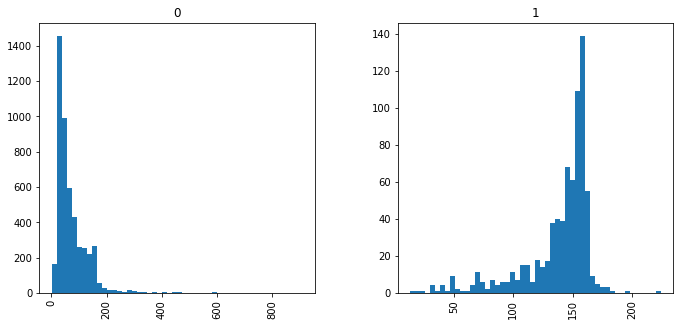

In [18]:
df.hist(column='length', by='Class', bins=50,figsize=(11,5))

### Text Pre-processing

In the next step we clean text, remove stop words and apply stemming operation for each line of text:

In [19]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [20]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)


In [22]:
df['Text'] = df['Text'].apply(clean_text)
df.head()

,Class,Text,length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


In [23]:
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [24]:
df.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [25]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

49940


After text cleaning and removing stop words, we have only 49 940 words.

### Vectorization

To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.

First we spliting the data into X and y values:

In [26]:
X = df['Text']
y = df['Class']

Now, we create a numerical feature vector for each document:

In [27]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(X).toarray()

In [28]:
# Creating a pickle file for the CountVectorizer
pickle.dump(cv, open('cv-transform.pkl', 'wb'))

We spliting the data into train and test sets:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457, 2500)
(1115, 2500)
(4457,)
(1115,)


**SMOTE**

The target class variable is imbalanced, "ham" values are more dominating than "spam". 
The simplest way to improve imbalanced dataset is balancing them by oversampling instances of the minority class or undersampling instances of the majority class. We will try to balancing classes by using one of the advanced techniques like the SMOTE method (Synthetic Minority Over-sampling Technique).

SMOTE technique  is one of the most commonly used oversampling methods to solve the imbalance problem. It goal is to balance class distribution by randomly increasing  minority class examples by replicating them.  

We will use imbalanced-learn library to apply SMOTE method:

In [30]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [31]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(7752, 2500)
(7752,)


In [32]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.3)
classifier.fit(X_train_sm, y_train_sm)

MultinomialNB(alpha=0.3)

In [33]:
pred_y=classifier.predict(X_test)

In [34]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(y_test, pred_y))

accuracy 0.9730941704035875
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       949
           1       0.92      0.90      0.91       166

    accuracy                           0.97      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.97      0.97      0.97      1115



In [35]:
# Creating a pickle file for the Multinomial Naive Bayes model
import pickle
filename = 'spam-sms-mnb-model.pkl'
pickle.dump(classifier, open(filename, 'wb'))